

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 7 - Generative Models - Autoencoders and GANs 



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Pavlos Protopapas and Mark Glickman 


<hr style="height:2pt">

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit (excluding large networks)
- Please note that the model training in this assignment can take a long time (even on a GPU). Expect to train for more than 2-3hrs per model.

<hr style="height:2pt">

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [39]:
#PLEASE RUN THIS CELL 
import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.layers import *
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.preprocessing.image import ImageDataGenerator
import random


from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Question 1: Making Faces [97 pts]  </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Part A:  Preparing the Data [10 pts]

**1.A.1.** Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip). In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).  

**1.A.2.** Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.

**1.A.3.** Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.

## Solution: Part A

### 1.A.2.

In [40]:
attr = pd.read_csv('data/list_attr_celeba.csv')
attr_cols = list(set(attr.columns)^set(['image_id']))

### 1.A.1.

In [41]:
# # Unzip data sets
# ! unzip data/celeba-dataset.zip
# ! unzip img_align_celeba.zip

In [42]:
img_dir = 'data/img_align_celeba'
batch = 64

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
    dataframe=attr, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="training",
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch
    )

val_generator = datagen.flow_from_dataframe(
    dataframe=attr, directory=img_dir, 
    x_col='image_id', y_col=attr_cols,
    subset="validation",
    seed=42, shuffle=True, 
    class_mode='input', 
    batch_size=batch,
    )

Found 151950 images.
Found 50649 images.


(218, 178, 3)


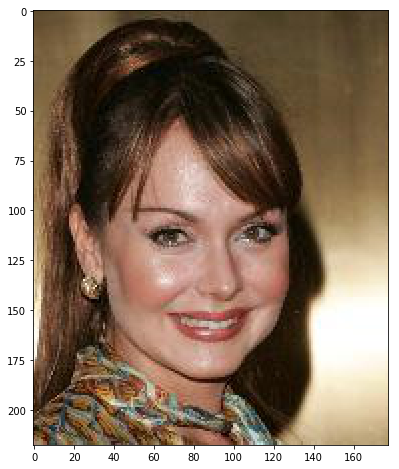

In [43]:
plt.figure(figsize=(20,8))
img = imread('data/img_align_celeba/000009.jpg')
plt.imshow(img, cmap='gray')
print(img.shape)

### 1.A.3.

In [44]:
rand_img = np.random.choice(attr['image_id'], 3)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
118738,118739.jpg,-1,1,-1,-1,-1,-1,1,1,-1,...,-1,1,1,-1,1,-1,1,1,-1,1


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
126010,126011.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
119308,119309.jpg,-1,1,-1,1,-1,1,-1,1,1,...,-1,1,-1,-1,1,-1,1,1,-1,-1


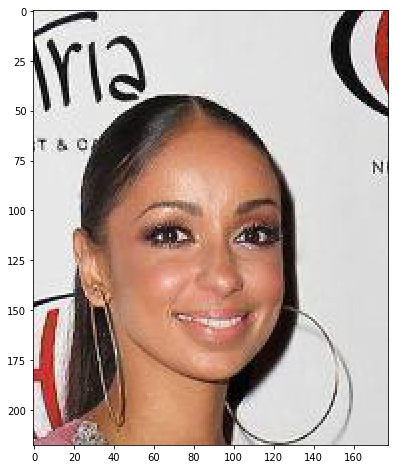

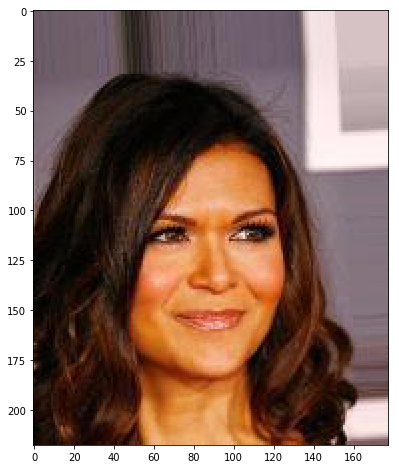

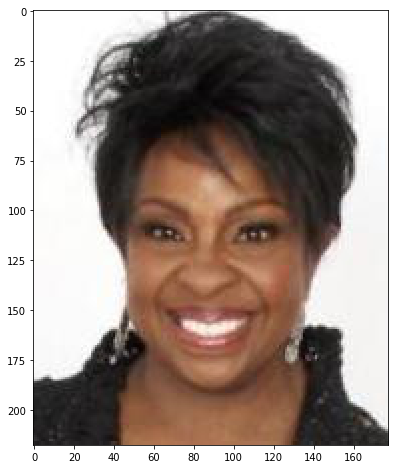

In [45]:
for i in rand_img:
    plt.figure(figsize=(20,8))
    img = imread('data/img_align_celeba/%s'%i)
    plt.imshow(img, cmap='gray')
    display(attr[attr['image_id']==i])

### Part B: Building and Training a Variational Autoencoder Model [44 pts]

**1.B.1.** Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.

**1.B.2.** Train your model on the images in the celebA dataset.

**1.B.3.** Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.  How do they compare?

**1.B.4.** Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.  See below for an example.

![](latent_1.png)

**1.B.5.** Generate and visualise around 15 celebrity faces not in your training set.  How do the generated faces compare in quality to celebrity faces from the training samples?

#### Please note that the VAE model can take a long time to train before you obtain decent results. Expect to train for more than 2-3hrs depending on the batch size

## Solution: Part B

In [46]:
# store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

### 1.B.1.

In [74]:
image_shape = train_generator.image_shape
image_shape

(256, 256, 3)

In [75]:
latent_dim = 2

# input layer
input_layer = Input(shape=image_shape)

# encoding architecture
x = Conv2D(32, 3,
                  padding='same', 
                  activation='relu')(input_layer)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu',
                  strides=(2, 2))(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)
x = Conv2D(64, 3,
                  padding='same', 
                  activation='relu')(x)

# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [76]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [77]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='relu',
                           strides=(2, 2))(x)
x = Conv2D(1, 3,
                  padding='same', 
                  activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [78]:
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_layer, z_decoded])

In [71]:
def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    # Reconstruction loss
    xent_loss = binary_crossentropy(x, z_decoded)
    # KL divergence
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [81]:
vae = Model(input_layer, y)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 32) 896         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 128, 64) 18496       conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 

### 1.B.2.

In [82]:
STEP_SIZE_TRAIN= int(train_generator.n//train_generator.batch_size)
STEP_SIZE_VALID= int(val_generator.n//val_generator.batch_size)

history = vae.fit_generator(generator=train_generator,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                validation_data=val_generator,
                                validation_steps=STEP_SIZE_VALID,
                                epochs=10)

Epoch 1/10


InvalidArgumentError: Incompatible shapes: [4194304] vs. [12582912]
	 [[{{node custom_variational_layer_3/logistic_loss/mul}} = Mul[T=DT_FLOAT, _class=["loc:@train...ad/Reshape"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](custom_variational_layer_3/Log, loss_6/custom_variational_layer_3_loss/Reshape_1)]]
	 [[{{node loss_6/add/_855}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_1315_loss_6/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [23]:
store_keras_model(model, 'model_vae_norm')

Saved model to disk


In [21]:
model = load_keras_model('model_vae_norm')

### Part C: Building and Training a DCGAN Model [43 pts]

**1.C.1.** Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.

**1.C.2.** Train your model on the images in the celeba dataset.

**1.C.3.** Generate and visualise around 15 celebrity faces.  How do the generated faces compare in quality to celebrity faces from the training samples? How do they compare in quality to the faces generated via VAE?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs

## Question 2: VAE-GANIME [3 pts - ALMOST OPTIONAL] 

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

We've provided you a dataset of anime faces and we want you to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  Again, you may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

### Part B: Building and Training a DCGAN 

**2.B.1.** Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models

**2.B.2.** Train your model on the images in the anime faces dataset.

**2.B.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples?

### Part C: Building and Training a VAE-GAN 

**2.C.1.** Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models

**2.C.2.** Train your model on the images in the anime faces dataset.

**2.C.3.** Generate and visualise around 15 anime faces not in your training set.  How do the generated faces compare in quality to anime faces from the training samples? How do they compare to the faces from the traditional GAN?

#### Please note that the DCGAN model can take a long time to train before you obtain good results. Expect to train for more than 2 hrs depending on the batch size and number of epochs